# Optimizer

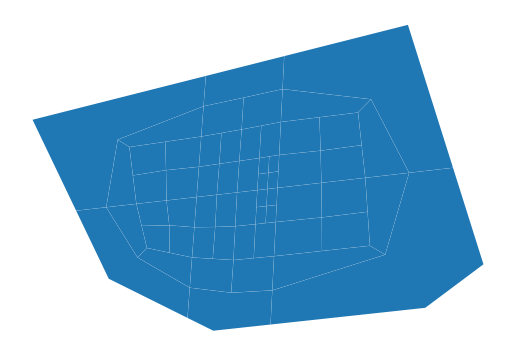

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_file('sveto.geojson')[['geometry']]
blocks_gdf.geometry = blocks_gdf.buffer(-0.5)
blocks_gdf = gpd.GeoDataFrame(blocks_gdf.geometry.explode(True)).reset_index(drop=True)
blocks_gdf.plot().set_axis_off()

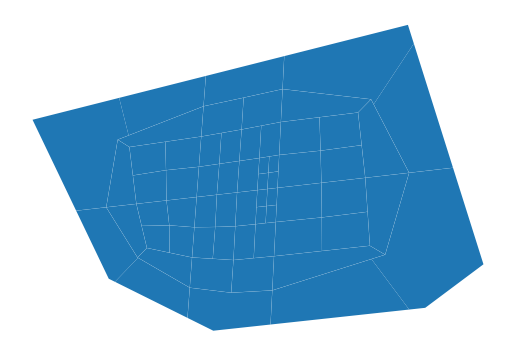

In [2]:
from blocksnet.preprocessing import LandUseOptimizer
import networkx as nx

luo = LandUseOptimizer(blocks_gdf)
luo.blocks.plot().set_axis_off()

In [3]:
from blocksnet import LandUse

lu_shares = {
  LandUse.RESIDENTIAL: 0.15,
  LandUse.BUSINESS: 0.15,
  LandUse.RECREATION: 0.15,
  LandUse.SPECIAL: 0.15,
  LandUse.INDUSTRIAL: 0.15,
  LandUse.AGRICULTURE: 0.15,
  LandUse.TRANSPORT: 0.10
}

best_X, best_value, Xs, values = luo.run(lu_shares, rate=0.999, max_iter=100_000)

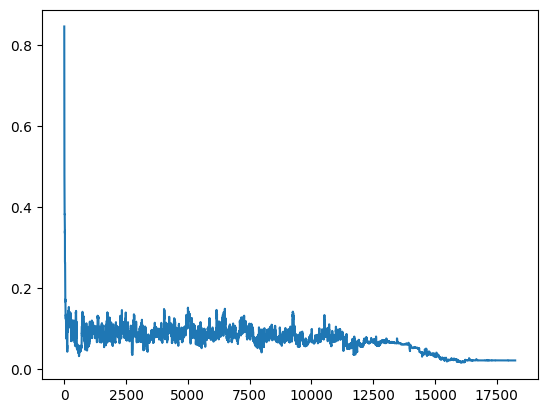

In [4]:
import matplotlib.pyplot as plt

plt.plot(values)

In [5]:
data = [{lu.value : share for lu,share in luo.to_shares_dict(X).items()} for X in Xs]

<Axes: >

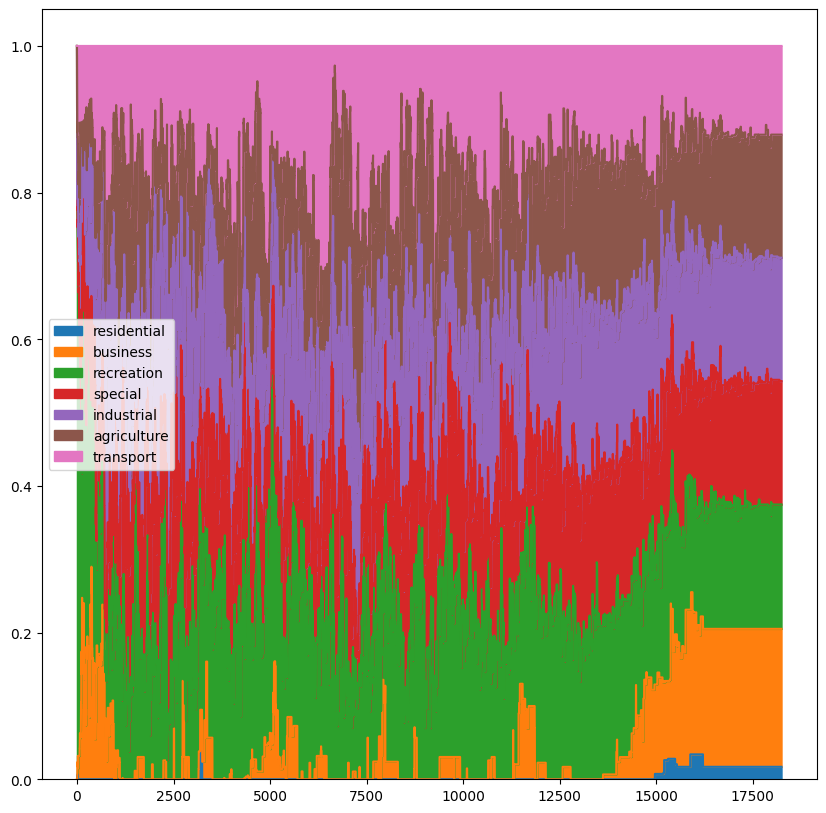

In [6]:
import pandas as pd

df = pd.DataFrame(data)
df.plot(kind='area', stacked=True, figsize=(10,10))

In [7]:
luo.to_gdf(best_X).to_crs(4326).to_file('land_use.geojson')

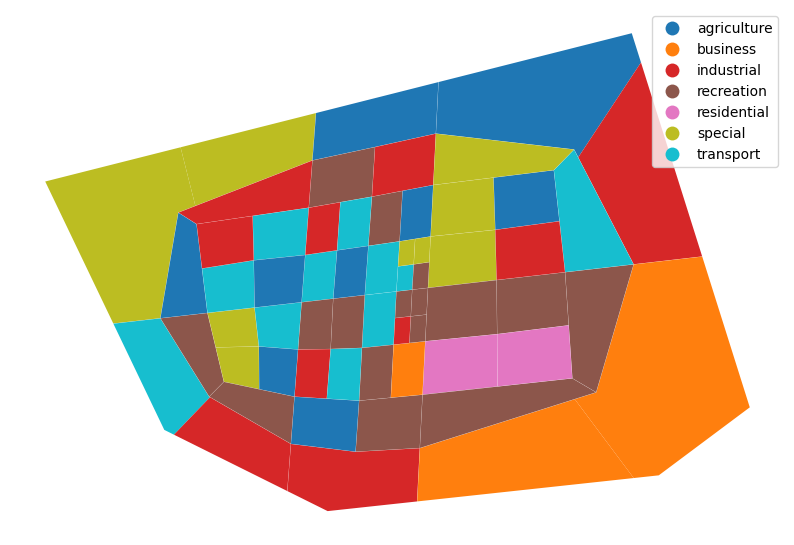

In [8]:
luo.to_gdf(best_X).plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()